# Marina Lebedina
## ID: 12249127

# HW 2. Futures Spread Trading

### Period: December 2, 2017 - August 31, 2019
### 2nd month: number of days to futures expiration is the smalles available value greater than 30 days
### $X = $ ICE_B_B $\Rightarrow$ Brent Crude Oil, contract unit = 1,000 barrels, price q
### $Y = $ ICE_G_G $\Rightarrow$ Low Sulphur Gasoil, contract unit = 100 metric tons

$$ X_t = \text{ICE_B_B}_t $$

$$ Y_t = \text{ICE_G_G}_t $$

$$ r_t = Y_t - X_t $$

$$ \overline{r}_t^{(M)} = MA_{r_t}^{(M)}$$ 

$$ s_t^{(M)} = r_t - \overline{r}_t^{(M)}, M=[10,20,30,40] $$

**ICE_B_B: Brent Crude Oil** 

- contract unit = 1,000 barrels

- price quotation = U.S. dollars and cents per barrel

- reference: https://www.cmegroup.com/trading/energy/crude-oil/brent-crude-oil_contract_specifications.html

**ICE_G_G: Low Sulfur Gasoil**

- contract unit = 100 metric tons

- price quotation = U.S. dollars and cents per metric ton

- reference: https://www.cmegroup.com/trading/energy/refined-products/european-gasoil-ice-futures_contractSpecs_futures.html

# 1. Data Processing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import time
from scipy.stats import kurtosis, kurtosistest, skew, skewtest, norm, jarque_bera
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from calendar import monthrange
from tqdm import tnrange
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

@functools.lru_cache(maxsize=1600)
def fetch_quandl(my_data_items, trim_start=None, trim_end=None):
    qdata = quandl.get(list(my_data_items), returns="pandas", 
                      trim_start=trim_start, trim_end=trim_end,
                      api_key="bWbMQmPczynWg63DzkA9")
    return qdata

def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

In [2]:
contract1 = 'CBT_FV_FV'
contract2 = 'CBT_TY_TY'

multiplier = 1/7.45

start = '2017-12-02'
end = '2019-08-31'

dates = pd.bdate_range(start=start, end=end)
df = pd.DataFrame(index=dates, columns=['Xt', 'DtT_X', 'Yt', 'DtT_Y', 'rt'])

months = ['H', 'M', 'U','Z'] # March, June, September, December
years = ['2018', '2019']
    
for yy in tnrange(len(years), desc='Iterating through years'):
    y = years[yy]
    for mm in tnrange(len(months), desc='Iterating through months'):
        m = months[mm]
        
        # Download from Quandl
        X_specif = 'OWF/{}IVM'.format(contract1 + '_' + m + y + '_')
        Y_specif = 'OWF/{}IVM'.format(contract2 + '_' + m + y + '_')
        
        X = clean_quandl_columns(fetch_quandl((X_specif,), trim_start=start, trim_end=end))
        Y = clean_quandl_columns(fetch_quandl((Y_specif,), trim_start=start, trim_end=end))
        data = X[['Future', 'DtT']]
        data = data.rename(columns={"Future": "Xt", "DtT": "DtT_X"})
        data['Yt'] = Y['Future']*multiplier
        data['DtT_Y'] = Y['DtT']
        data['rt'] = data['Yt'] - data['Xt']

        for i,j in data.iterrows():
            if j['DtT_X'] <= 30 or j['DtT_Y'] <= 30:
                start = i
                break
            else:
                Xt = j['Xt']
                Yt = j['Yt']
                Xt_dt = j['DtT_X']
                Yt_dt = j['DtT_Y']
                rt = j['rt']
                df.loc[i] = [Xt, Xt_dt, Yt, Yt_dt, rt] 
                
print(df[pd.isnull(df).any(axis=1)].index)
df.dropna(inplace=True)
print(df[pd.isnull(df).any(axis=1)].index)



DatetimeIndex(['2017-12-25', '2018-01-01', '2019-01-01'], dtype='datetime64[ns]', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


# 2. Implementation of Trading Strategy

In [3]:
def data_prep(df, N):
    data = df.copy()
    data['rt_MA20'] = data['rt'].rolling(N).mean()
    data['st_20'] = data['rt'] - data['rt_MA20']
    data.dropna(inplace=True)

    data = data.reset_index().rename(columns={'index': 'Date'})
    data['Indicator'] = np.nan

    for t in range(data.shape[0]):
        if t == 0:
            data['Indicator'][t] = 'Start'
        elif t == data.shape[0]-1:
             data['Indicator'][t] = 'End'
        else:
            date = data['Date'][t]
            date_prev = data['Date'][t-1]
            if date.month == date_prev.month:
                data['Indicator'][t] = 'no action'
            elif date.month > date_prev.month:
                data['Indicator'][t] = 'Start'
                data['Indicator'][t-1] = 'End'
            elif date.month < date_prev.month:
                data['Indicator'][t] = 'Start'
                data['Indicator'][t-1] = 'End'
    return data
                
def plot_st(data, j, g, N):
    plt.figure(figsize=(16,7))
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('$s_t^N, N = {}$'.format(N), fontsize=14)
    plt.suptitle('Dynamics of $s_t^N, N = {}$'.format(N), fontsize=18)
    data.set_index('Date')['st_20'].plot(label='$s_t^N, N = {}$'.format(N), color='blue', linewidth=2)

    plt.axhline(y=g, color='orange', linestyle='--', linewidth=2)
    plt.axhline(y=j, color='brown', linestyle='--', linewidth=2)
    plt.axhline(y=-g, color='orange', linestyle='--', linewidth=2)
    plt.axhline(y=-j, color='brown', linestyle='--', linewidth=2)
    plt.text(np.array(data['Date'])[-1], j-0.06, 'j = {}'.format(j))
    plt.text(np.array(data['Date'])[-1], g+0.01, 'g = {}'.format(g))
    plt.text(np.array(data['Date'])[-1], -j+0.01, '-j = {}'.format(-j))
    plt.text(np.array(data['Date'])[-1], -g-0.06, '-g = {}'.format(-g))

    plt.legend(fontsize=12)
    None
    
def plot_PnL(data):
    plt.figure(figsize=(17,6))
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('PnL, $', fontsize=14)
    plt.suptitle('Dynamics of Mark-to-Market value for Open Positions, $', fontsize=18)
    data.set_index('Date')['Daily_MtoM'].plot(label='Daily mark-to-market for open position, $', 
                                                  color='purple', linewidth=2)
    plt.axhline(y=0, color='g', linestyle=':', linewidth=2, label='PnL = $0')
    plt.axhline(y=-K*S, color='r', linestyle=':', linewidth=2, label='Stop Loss')
    plt.legend()
    None

    plt.figure(figsize=(17,6))
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('PnL, $', fontsize=14)
    plt.suptitle('Dynamics of Cumulative PnL, $', fontsize=18)
    plt.plot(trades.set_index('Enter')['PnL_cum'],label='Cumulative PnL, $', color='blue', linewidth=2)
    plt.axhline(y=0, color='g', linestyle=':', linewidth=2, label='PnL = $0')
    plt.legend()
    None
    
def plot_signals(data, N):
    fig, ax1 = plt.subplots(figsize=(18,8))

    ax1.plot(data.set_index('Date')['st_20'], label='$s_t^N, N = {}$'.format(N), color='blue', linewidth=2)
    ax1.axhline(y=g,  color='orange', linestyle='--', linewidth=1)
    ax1.axhline(y=j,  color='brown', linestyle='--', linewidth=1)
    ax1.axhline(y=-j, color='brown', linestyle='--', linewidth=1)
    ax1.axhline(y=-g, color='orange', linestyle='--', linewidth=1)

    plt.text(np.array(data['Date'])[-1], j-0.06, 'j = {}'.format(j))
    plt.text(np.array(data['Date'])[-1], g+0.01, 'g = {}'.format(g))
    plt.text(np.array(data['Date'])[-1], -j+0.01, '-j = {}'.format(-j))
    plt.text(np.array(data['Date'])[-1], -g-0.06, '-g = {}'.format(-g))

    mask_buy = (data['Signal'] == 1.0) & (data['Idea']=='BUY spread')
    mask_sell = (data['Signal'] == -1.0) & (data['Idea']=='SELL spread')
    mask_flatten = ((data['Idea']=='BUY spread (flattening)') | (data['Idea']=='SELL spread (flattening)'))
    sig_buy = data[mask_buy]
    sig_sell = data[mask_sell]
    sig_flatten = data[mask_flatten]

    ax1.scatter(sig_buy['Date'], sig_buy['st_20'], label='signal "buy"', color='g', marker = '^', linewidth=4)
    ax1.scatter(sig_sell['Date'], sig_sell['st_20'], label='signal "sell"', color='r', marker = 'v', linewidth=4)
    ax1.scatter(sig_flatten['Date'], sig_flatten['st_20'], label='signal "buy/sell" to flatten',
               color='orange', marker = 'o', linewidth=4)
    ax1.legend()
    plt.suptitle('Dynamics of $s_t^N, N = {}$ and trading signals'.format(N), fontsize=18)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('$s_t^N, N = {}$'.format(N), fontsize=14)
    None
    

def trading_strategy(data,j,g,S,K,verbose):
    
    data['Idea'] = np.nan
    data['Signal'] = np.nan
    data['Contracts_Xt'] = np.nan
    data['Contracts_Yt'] = np.nan
    data['Notional_Xt'] = np.nan
    data['Notional_Yt'] = np.nan
    data['Position_PnL'] = 0.0
    data['Daily_MtoM'] = 0.0
    data['Daily_PnL'] = 0.0
    data['Daily_return'] = 0.0
    
    indices = np.arange(0,1000)
    trades = pd.DataFrame(index=indices, columns = ['Enter', 'Exit', 'Not_X', 'Not_Y', 
                                                    'Enter_$', 'Exit_$', 'Cum_period_PnL', 'Position'])

    is_long = False
    is_short = False

    just_opened = False

    stop_loss = 0

    total_pnl = 0.0

    idx = 0

    for t in range(data.shape[0]):

        just_opened = False

        position_Xt = round(notional / (data['Xt'][t]*Xt_contract_size), 0)
        notional_Xt = data['Xt'][t]*Xt_contract_size*position_Xt 

        position_Yt = round(notional_Xt / (data['Yt'][t]*Yt_contract_size), 0)
        notional_Yt = data['Yt'][t]*Yt_contract_size*position_Yt

        if data['Indicator'][t] == 'End':

            if is_long == True:
                is_long = False
                is_short = False
                data['Idea'][t] = 'SELL spread (closing)'
                data['Signal'][t] = -1
                data['Notional_Xt'][t] = notional_Xt
                data['Notional_Yt'][t] = notional_Yt
                data['Contracts_Xt'][t] = position_Xt
                data['Contracts_Yt'][t] = position_Yt
                data['Position_PnL'][t] = notional_Yt + (-1)*notional_Xt # close long position
                data['Daily_MtoM'][t] = trades['Enter_$'][idx] + data['Position_PnL'][t]
                data['Daily_PnL'][t] = data['Daily_MtoM'][t] - data['Daily_MtoM'][t-1]
                data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])
                total_pnl += data['Daily_MtoM'][t]
                trades['Exit'][idx] = data['Date'][t]
                trades['Exit_$'][idx] = data['Position_PnL'][t]
                trades['Cum_period_PnL'][idx] = data['Daily_MtoM'][t]
                idx += 1

            elif is_short == True:
                is_short = False
                is_long = False
                data['Idea'][t] = 'BUY spread (closing)'
                data['Signal'][t] = 1
                data['Notional_Xt'][t] = notional_Xt
                data['Notional_Yt'][t] = notional_Yt
                data['Contracts_Xt'][t] = position_Xt
                data['Contracts_Yt'][t] = position_Yt
                data['Position_PnL'][t] = (-1)*notional_Yt + notional_Xt # close short position
                data['Daily_MtoM'][t] = trades['Enter_$'][idx] + data['Position_PnL'][t]
                data['Daily_PnL'][t] = data['Daily_MtoM'][t] - data['Daily_MtoM'][t-1]
                data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])
                total_pnl += data['Daily_MtoM'][t]
                trades['Exit'][idx] = data['Date'][t]
                trades['Exit_$'][idx] = data['Position_PnL'][t]
                trades['Cum_period_PnL'][idx] = data['Daily_MtoM'][t]
                idx += 1

            else:
                data['Idea'][t] = 'Do nothing (closing)'
                data['Signal'][t] = 0
                data['Notional_Xt'][t] = 0
                data['Notional_Yt'][t] = 0
                data['Contracts_Xt'][t] = 0
                data['Contracts_Yt'][t] = 0

        else:

            if data['Date'][t].month == stop_loss:
                data['Indicator'][t] = 'stop loss'
                continue

            else:
                stop_loss = 0

                ############################# SELL SPREAD #############################
                # SELL SPREAD -> we expect it to revert to the mean => sell expensive one, buy cheap
                # Open new position
                if data['st_20'][t] > g \
                and is_long == False and is_short == False: # Y > X, sell Y, buy X
                    is_long = False
                    is_short = True
                    just_opened = True
                    data['Idea'][t] = 'SELL spread'
                    data['Signal'][t] = -1
                    data['Notional_Xt'][t] = notional_Xt
                    data['Notional_Yt'][t] = notional_Yt
                    data['Contracts_Xt'][t] = position_Xt
                    data['Contracts_Yt'][t] = position_Yt
                    traded_cash = np.abs(notional_Yt) + np.abs(notional_Xt)
                    trades['Enter'][idx] = data['Date'][t]
                    trades['Enter_$'][idx] = notional_Yt + (-1)*notional_Xt # sell Y, buy X
                    trades['Not_X'][idx] = notional_Xt
                    trades['Not_Y'][idx] = notional_Yt
                    trades['Position'][idx] = 'Short'
                    data['Position_PnL'][t] = (-1)*notional_Yt + notional_Xt
                    data['Daily_MtoM'][t] = data['Position_PnL'][t] + trades['Enter_$'][idx]
                    data['Daily_PnL'][t] = 0
                    data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])

                # Close existing position
                elif data['st_20'][t] > g \
                and is_long == True and is_short == False: # Y > X
                    is_long = False
                    is_short = False
                    data['Idea'][t] = 'SELL spread (closing)'
                    data['Signal'][t] = -1
                    data['Notional_Xt'][t] = notional_Xt
                    data['Notional_Yt'][t] = notional_Yt
                    data['Contracts_Xt'][t] = position_Xt
                    data['Contracts_Yt'][t] = position_Yt
                    data['Position_PnL'][t] = notional_Yt + (-1)*notional_Xt # sell Y, buy X
                    data['Daily_MtoM'][t] = trades['Enter_$'][idx] + data['Position_PnL'][t]
                    total_pnl += data['Daily_MtoM'][t]
                    trades['Exit'][idx] = data['Date'][t]
                    trades['Exit_$'][idx] = data['Position_PnL'][t]
                    trades['Cum_period_PnL'][idx] = data['Daily_MtoM'][t]
                    data['Daily_PnL'][t] = data['Daily_MtoM'][t] - data['Daily_MtoM'][t-1]
                    data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])
                    idx += 1

                # Hold
                elif data['st_20'][t] > g and data['st_20'][t] > j \
                and is_long == False and is_short == True: # Y > X
                    data['Idea'][t] = 'HOLD short position'
                    data['Signal'][t] = 0
                    data['Notional_Xt'][t] = 0 
                    data['Notional_Yt'][t] = 0
                    data['Contracts_Xt'][t] = 0
                    data['Contracts_Yt'][t] = 0

                elif data['st_20'][t] > g \
                and is_long == True and is_short == True: # Y > X
                    print('Mistake!')

                    ############################# BUY SPREAD #############################
                # BUY SPREAD -> we expect it to revert to the mean => sell expensive one, buy cheap
                # Open new position
                elif data['st_20'][t] < -g \
                and is_short == False and is_long == False: 
                    is_long = True
                    is_short = False
                    just_opened = True
                    data['Idea'][t] = 'BUY spread'
                    data['Signal'][t] = 1
                    data['Notional_Xt'][t] = notional_Xt
                    data['Notional_Yt'][t] = notional_Yt
                    data['Contracts_Xt'][t] = position_Xt
                    data['Contracts_Yt'][t] = position_Yt
                    traded_cash = np.abs(notional_Yt) + np.abs(notional_Xt)
                    trades['Enter'][idx] = data['Date'][t]
                    trades['Enter_$'][idx] = (-1)*notional_Yt + notional_Xt 
                    trades['Not_X'][idx] = notional_Xt
                    trades['Not_Y'][idx] = notional_Yt
                    trades['Position'][idx] = 'Long'
                    data['Position_PnL'][t] = notional_Yt + (-1)*notional_Xt
                    data['Daily_MtoM'][t] = data['Position_PnL'][t] + trades['Enter_$'][idx]
                    data['Daily_PnL'][t] = 0
                    data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])

                # Close existing position
                elif data['st_20'][t] < -g \
                and is_short == True and is_long == False: # Y < X
                    is_long = False
                    is_short = False
                    data['Idea'][t] = 'BUY spread (closing)'
                    data['Signal'][t] = 1
                    data['Notional_Xt'][t] = notional_Xt
                    data['Notional_Yt'][t] = notional_Yt
                    data['Contracts_Xt'][t] = position_Xt
                    data['Contracts_Yt'][t] = position_Yt
                    data['Position_PnL'][t] = notional_Yt + (-1)*notional_Xt # have Y, don't have X
                    data['Daily_MtoM'][t] = trades['Enter_$'][idx] + data['Position_PnL'][t]
                    total_pnl += data['Daily_MtoM'][t]
                    trades['Exit'][idx] = data['Date'][t]
                    trades['Exit_$'][idx] = data['Position_PnL'][t]
                    trades['Cum_period_PnL'][idx] = data['Daily_MtoM'][t]
                    data['Daily_PnL'][t] = data['Daily_MtoM'][t] - data['Daily_MtoM'][t-1]
                    data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])
                    idx += 1

                # Hold
                elif data['st_20'][t] < -g \
                and is_short == True and is_long == False: # Y < X
                    data['Idea'][t] = 'HOLD long position'
                    data['Signal'][t] = 0
                    data['Notional_Xt'][t] = 0 
                    data['Notional_Yt'][t] = 0
                    data['Contracts_Xt'][t] = 0
                    data['Contracts_Yt'][t] = 0

                elif data['st_20'][t] < -g \
                and is_short == True and is_long == True:
                    print('Mistake!')

                    ############################# FLATTEN POSITION #############################
                # Close existing position
                elif data['st_20'][t] < j and data['st_20'][t] > -j \
                and is_short == True and is_long == False: # sold Y, bought X
                    is_long = False
                    is_short = False
                    data['Idea'][t] = 'BUY spread (flattening)'
                    data['Signal'][t] = 1
                    data['Notional_Xt'][t] = notional_Xt
                    data['Notional_Yt'][t] = notional_Yt
                    data['Contracts_Xt'][t] = position_Xt
                    data['Contracts_Yt'][t] = position_Yt
                    data['Position_PnL'][t] = (-1)*notional_Yt + notional_Xt # buy Y, sell X
                    data['Daily_MtoM'][t] = trades['Enter_$'][idx] + data['Position_PnL'][t]
                    total_pnl += data['Daily_MtoM'][t]
                    trades['Exit'][idx] = data['Date'][t]
                    trades['Exit_$'][idx] = data['Position_PnL'][t]
                    trades['Cum_period_PnL'][idx] = data['Daily_MtoM'][t]
                    data['Daily_PnL'][t] = data['Daily_MtoM'][t] - data['Daily_MtoM'][t-1]
                    data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])
                    idx += 1

                elif data['st_20'][t] < j and data['st_20'][t] > -j \
                and is_short == False and is_long == True: # sold X, bought Y
                    is_long = False
                    is_short = False
                    data['Idea'][t] = 'SELL spread (flattening)'
                    data['Signal'][t] = -1
                    data['Notional_Xt'][t] = notional_Xt
                    data['Notional_Yt'][t] = notional_Yt
                    data['Contracts_Xt'][t] = position_Xt
                    data['Contracts_Yt'][t] = position_Yt
                    data['Position_PnL'][t] = notional_Yt + (-1)*notional_Xt # buy X, sell Y
                    data['Daily_MtoM'][t] = trades['Enter_$'][idx] + data['Position_PnL'][t]
                    total_pnl += data['Daily_MtoM'][t]
                    trades['Exit'][idx] = data['Date'][t]
                    trades['Exit_$'][idx] = data['Position_PnL'][t]
                    trades['Cum_period_PnL'][idx] = data['Daily_MtoM'][t]
                    data['Daily_PnL'][t] = data['Daily_MtoM'][t] - data['Daily_MtoM'][t-1]
                    data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])
                    idx += 1

                    ############################# WE ARE INSIDE BANDS #############################
                # NO SIGNAL
                else:
                    data['Idea'][t] = 'HOLD position'
                    data['Signal'][t] = np.nan
                    data['Notional_Xt'][t] = 0 
                    data['Notional_Yt'][t] = 0 
                    data['Contracts_Xt'][t] = 0
                    data['Contracts_Yt'][t] = 0

                if is_long == True and just_opened == False and stop_loss == 0: # bought Y, sold X
                    data['Position_PnL'][t] = notional_Yt + (-1)*notional_Xt  # sell Y, buy X
                    if data['Idea'][t-1] != 'BUY spread (closing)' and \
                    data['Idea'][t-1] != 'SELL spread (closing)'\
                    and data['Idea'][t-1] != 'SELL spread (flattening)'\
                    and data['Idea'][t-1] != 'BUY spread (flattening)'\
                    and data['Signal'][t] != 1.0 and data['Signal'][t]!= -1.0:
                        data['Daily_MtoM'][t] = trades['Enter_$'][idx] + data['Position_PnL'][t]
                        data['Daily_PnL'][t] = data['Daily_MtoM'][t] - data['Daily_MtoM'][t-1]
                        data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])

                    else:
                        data['Daily_MtoM'][t] = data['Position_PnL'][t]
                        data['Daily_return'][t] = data['Daily_MtoM'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])

                    if data['Daily_MtoM'][t]  < -traded_cash*S:
                        if verbose==True:
                            print('STOP LOSS on {}:\ncumulative position loss = {:.2f}, stop loss threshold = {:.2f}, enter position notional = {:.2f}\n'.format(data['Date'][t], \
                                        data['Daily_MtoM'][t], -traded_cash*S, traded_cash))
                        is_short = False
                        is_long = False
                        data['Indicator'][t] = 'stop loss'
                        data['Idea'][t] = 'SELL spread (closing)'
                        data['Signal'][t] = -1
                        data['Notional_Xt'][t] = notional_Xt
                        data['Notional_Yt'][t] = notional_Yt
                        data['Contracts_Xt'][t] = position_Xt
                        data['Contracts_Yt'][t] = position_Yt
                        data['Position_PnL'][t] = notional_Yt + (-1)*notional_Xt # buy Y, sell X to close 
                        data['Daily_MtoM'][t] = trades['Enter_$'][idx] + data['Position_PnL'][t]
                        total_pnl += data['Daily_MtoM'][t]
                        stop_loss = data['Date'][t].month
                        trades['Exit'][idx] = data['Date'][t]
                        trades['Exit_$'][idx] = data['Position_PnL'][t]
                        trades['Cum_period_PnL'][idx] = data['Daily_MtoM'][t]
                        data['Daily_PnL'][t] = data['Daily_MtoM'][t] - data['Daily_MtoM'][t-1]
                        data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])
                        idx += 1

                elif is_short == True and just_opened == False and stop_loss == 0: # sold Y, bought X
                    data['Position_PnL'][t] = (-1)*notional_Yt + notional_Xt # buy Y, sell X
                    if data['Idea'][t-1] != 'BUY spread (closing)' \
                    and data['Idea'][t-1] != 'SELL spread (closing)'\
                    and data['Idea'][t-1] != 'SELL spread (flattening)'\
                    and data['Idea'][t-1] != 'BUY spread (flattening)'\
                    and data['Signal'][t] != 1.0 and data['Signal'][t]!= -1.0:
                        data['Daily_MtoM'][t] = trades['Enter_$'][idx] + data['Position_PnL'][t]
                        data['Daily_PnL'][t] = data['Daily_MtoM'][t] - data['Daily_MtoM'][t-1]
                        data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])
                    else:
                        data['Daily_MtoM'][t] = data['Position_PnL'][t]
                        data['Daily_PnL'][t] = 0
                        data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])

                    if data['Daily_MtoM'][t] < -traded_cash*S:
                        if verbose==True:
                            print('STOP LOSS on {}:\ncumulative position loss = {:.2f}, stop loss threshold = {:2f}, enter position notional = {:.2f}\n'.format(data['Date'][t], \
                                        data['Daily_MtoM'][t], -traded_cash*S, traded_cash))
                        is_short = False
                        is_long = False
                        data['Indicator'][t] = 'stop loss'
                        data['Idea'][t] = 'BUY spread (closing)'
                        data['Signal'][t] = 1
                        data['Notional_Xt'][t] = notional_Xt
                        data['Notional_Yt'][t] = notional_Yt
                        data['Contracts_Xt'][t] = position_Xt
                        data['Contracts_Yt'][t] = position_Yt
                        data['Position_PnL'][t] = (-1)*notional_Yt + notional_Xt # buy Y, sell X 
                        data['Daily_MtoM'][t] = trades['Enter_$'][idx] + data['Position_PnL'][t]
                        total_pnl += data['Daily_MtoM'][t]
                        stop_loss = data['Date'][t].month
                        trades['Exit'][idx] = data['Date'][t]
                        trades['Exit_$'][idx] = data['Position_PnL'][t]
                        trades['Cum_period_PnL'][idx] = data['Daily_MtoM'][t]
                        data['Daily_PnL'][t] = data['Daily_MtoM'][t] - data['Daily_MtoM'][t-1]
                        data['Daily_return'][t] = data['Daily_PnL'][t] / (trades['Not_X'][idx] + trades['Not_Y'][idx])
                        idx += 1

    trades.dropna(inplace=True)
    trades['PnL_cum'] = trades['Cum_period_PnL'].cumsum()
    pnl = np.array(trades['PnL_cum'])[-1]
    if verbose==True:
        print('\nCheck PnLs: {}'.format(total_pnl == pnl))
        print('Remained Long/Short open positions: {} / {}'.format(is_short, is_long))

    start = '2017-12-02'
    end = '2019-08-31'
    start_ = datetime.strptime(start, '%Y-%m-%d')
    end_ = datetime.strptime(end, '%Y-%m-%d')
    days = (end_ - start_).days

    trades['Period'] = np.nan
    trades['Return'] = 0.00
    for t in range(trades.shape[0]):
        trades['Period'][t] = int((trades['Exit'][t] - trades['Enter'][t]).days)
        trades['Return'][t] = (1 + trades['Cum_period_PnL'][t] / \
                               (trades['Not_X'][t] + trades['Not_Y'][t]))**(252/trades['Period'][t]) - 1

    # Return from cumulative PnL
    cum_ret = (total_pnl / K)
    ann_ret1 = (1+cum_ret)**(252/days) - 1

    # Return from Period Returns
    ann_ret2 = trades['Return'].mean()

    # Return from Daily Returns
    ann_ret3 = (1 + data['Daily_return'].mean())**(252/data.shape[0]) - 1
    ann_ret4 = data['Daily_return'].mean()

    if verbose==True:
        print('\nCapital invested = $ {:.2f}'.format(K))
        print('Cumulative PnL from strategy = $ {:.2f}'.format(pnl))

        print('\nAnnualized Return (from cum PnL) \t\t\t = {:.5f}%'.format(ann_ret1*100))
        print('Annualized Return (from period annualized returns) \t = {:.5f}%'.format(ann_ret2*100))
        print('Annualized Return (from simple daily returns) \t\t = {:.5f}%'.format(ann_ret3*100))
        print('Simple mean Return (from simple daily returns) \t\t = {:.5f}%'.format(ann_ret4*100))
    
    return data, trades, pnl, ann_ret1, ann_ret2, ann_ret3, ann_ret4

# 3. Analysis of trading strategy performance by varying its input parameters

In [4]:
K = 1000000
notional = 500000
Xt_contract_size = 1000
Yt_contract_size = 100
j, g, S = 0.26, 0.31, 0.00096


df_comparison = pd.DataFrame(index=['$N=10$', '$N=20$', '$N=30$', '$N=40$'],
                            columns=['Cumulative PnL, $', 'Annualized Return, %'])

for i in range(1,5):
    N = i*10
    data_df = data_prep(df, N)
    data, trades, pnl, ann_ret1, ann_ret2, ann_ret3, ann_ret4 = trading_strategy(data_df, j, g, S, K, False)
    df_comparison['Cumulative PnL, $']['$N={}$'.format(N)] = pnl
    df_comparison['Annualized Return, %']['$N={}$'.format(N)] = ann_ret1*100
    
print('For j = {}, g = {}, S = {}:\n'.format(j,g,S))
df_comparison

For j = 0.26, g = 0.31, S = 0.00096:



,"Cumulative PnL, $","Annualized Return, %"
$N=10$,4644.51,0.183481
$N=20$,32.7181,0.00129433
$N=30$,-3978.61,-0.157585
$N=40$,-8740.98,-0.346715


**Let us do comparison of dependence of strategy performance (cumulative PnL and annualized return) on the "window" used in Moving Average calculation using a constant set of parameters, i.e. using $j=0.26, g=0.31, S=0.00096$.**

As we can see from the table above, **performance of the strategy deteriorates as the size of the "window" increases**.

The general idea of the trading strategy is that spread will be reverting back to its mean value every time it deviates from it. Size of the "window" in the Moving Average determines the period which is used for calculation of this mean. As the size of the "window" increases, we use more distant values of the spread for mean calculation. As we can see from the ***graph below*** which shows dynamics of spread over time, spread has a quite obvious downward trend. **Presence of the trend can be one of the reasons why higher size of the Moving Average "window" deteriorates performance of the strategy, given the fact that in terms of this task we are using constant thresholds $j$ and $g$**. In the presence of the trend and because of usage of constant thresholds, more recent observations have higher predictive power in comparison to older ones. Probably usage of Bollinger Bands could solve this problem. Overall in terms of this task we can see that "window" size of 10 shows much better performance in terms of cumulative PnL and annualized return than "window" sizes of 20, 30 and 40. That is why in further analysis we will use **"window" size of 10.**

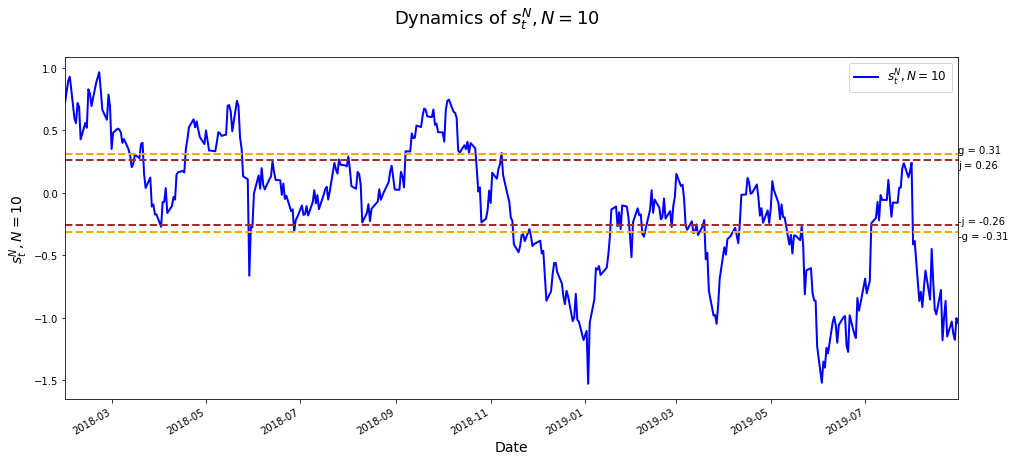

In [5]:
N = 10
data_df = data_prep(df, N)
plot_st(data, j, g, N)
None

In [6]:
N = 10
data_df = data_prep(df, N)
data, trades, pnl, ann_ret1, ann_ret2, ann_ret3, ann_ret4 = trading_strategy(data_df, j, g, S, K, True)

STOP LOSS on 2018-04-20 00:00:00:
cumulative position loss = -1133.81, stop loss threshold = -871.634497, enter position notional = 907952.60

STOP LOSS on 2019-05-29 00:00:00:
cumulative position loss = -1287.96, stop loss threshold = -896.91, enter position notional = 934281.25


Check PnLs: True
Remained Long/Short open positions: False / False

Capital invested = $ 1000000.00
Cumulative PnL from strategy = $ 4644.51

Annualized Return (from cum PnL) 			 = 0.18348%
Annualized Return (from period annualized returns) 	 = 0.19444%
Annualized Return (from simple daily returns) 		 = 0.00064%
Simple mean Return (from simple daily returns) 		 = 0.00113%


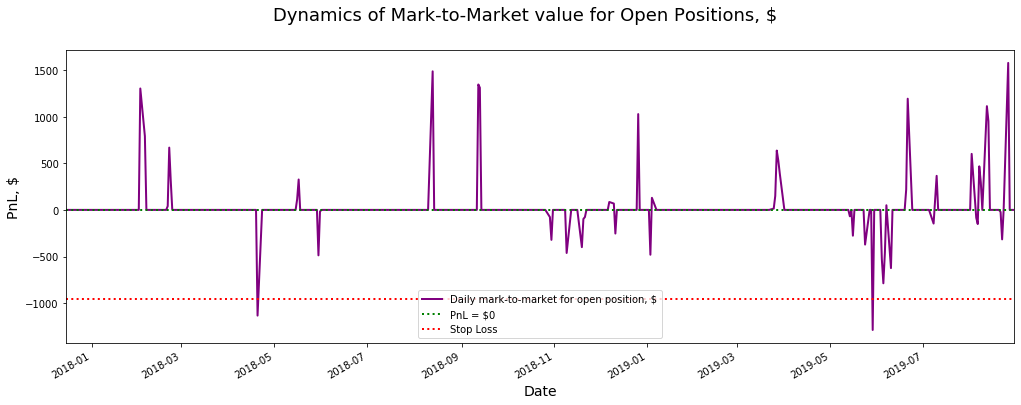

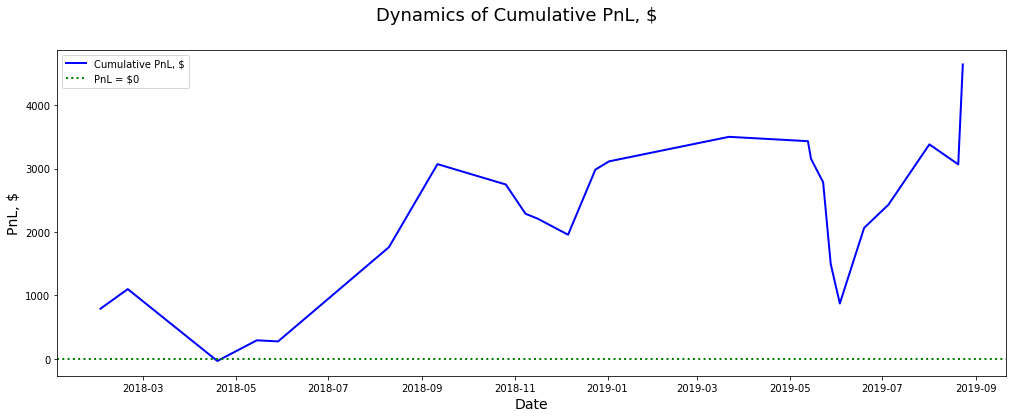

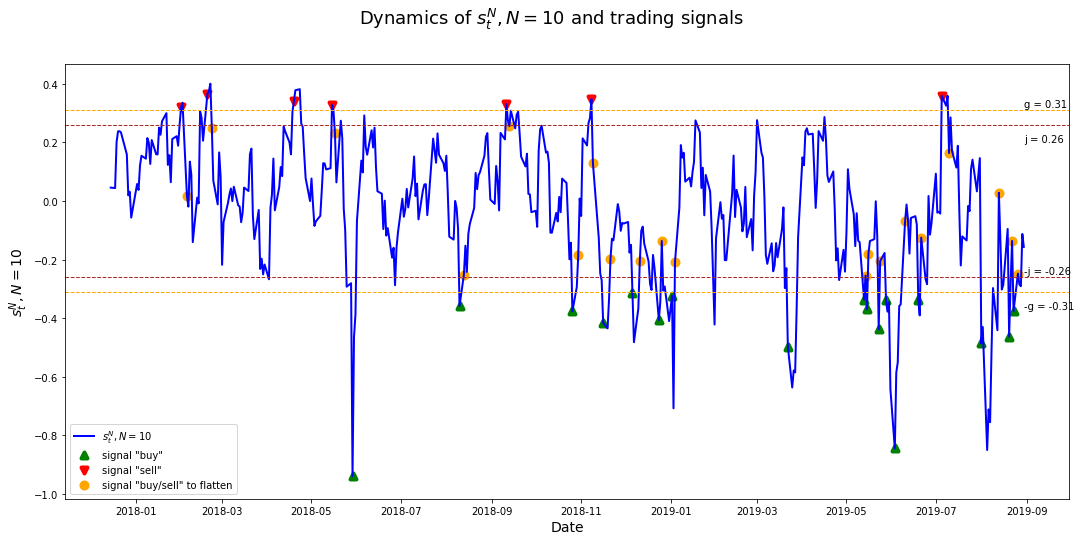

In [7]:
plot_PnL(data)
plot_signals(data, N)

Let us further analyze performance of the strategy by varying parameters $j$ and $g$ while keeping "window" size constant $N=10$. 

In [8]:
j_data = [0.18, 0.20, 0.26, 0.30, 0.31]
g_data = [0.22, 0.25, 0.31, 0.35, 0.38]
S = 0.00096
N = 10
df_comparison2 = pd.DataFrame(index=['$j=0.18, g=0.22$', '$j=0.2, g=0.25$', '$j=0.26, g=0.31$', \
                                     '$j=0.3, g=0.35$', '$j=0.31, g=0.38$'],
                            columns=['Cumulative PnL, $', 'Annualized Return, %', 'Number of positions'])
 
data_df = data_prep(df, N)
for i in range(len(j_data)):
    j = j_data[i]
    g = g_data[i]
    data, trades, pnl, ann_ret1, ann_ret2, ann_ret3, ann_ret4 = trading_strategy(data_df, j, g, S, K, False)
    df_comparison2['Cumulative PnL, $']['$j={}, g={}$'.format(j,g)] = pnl
    df_comparison2['Annualized Return, %']['$j={}, g={}$'.format(j,g)] = ann_ret1*100
    df_comparison2['Number of positions']['$j={}, g={}$'.format(j,g)] = trades.shape[0]
    
df_comparison2

,"Cumulative PnL, $","Annualized Return, %",Number of positions
"$j=0.18, g=0.22$",-6902.47,-0.273637,45
"$j=0.2, g=0.25$",-3116.4,-0.123402,40
"$j=0.26, g=0.31$",4644.51,0.183481,24
"$j=0.3, g=0.35$",6178.9,0.243985,20
"$j=0.31, g=0.38$",1246.64,0.0492992,14


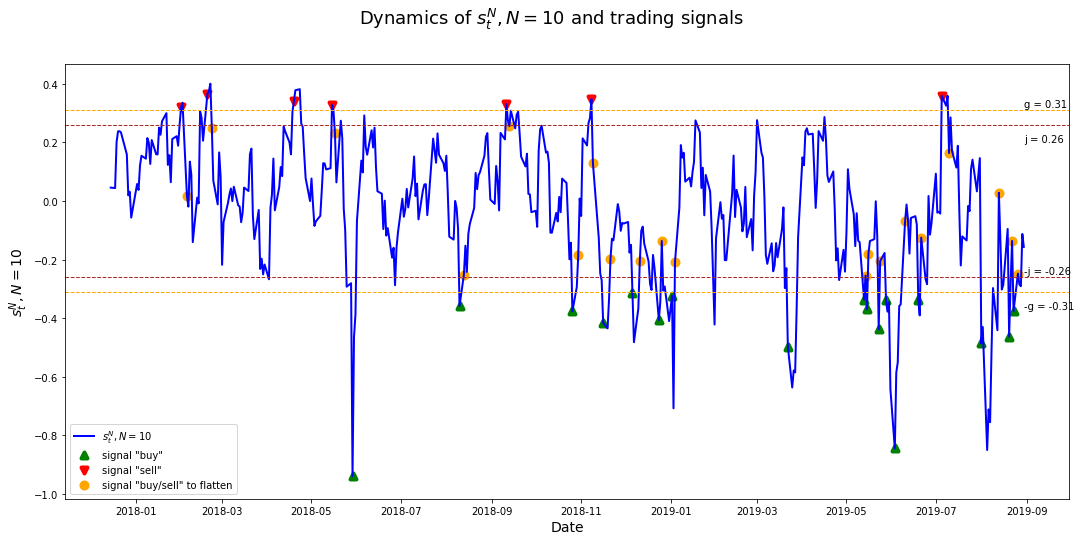

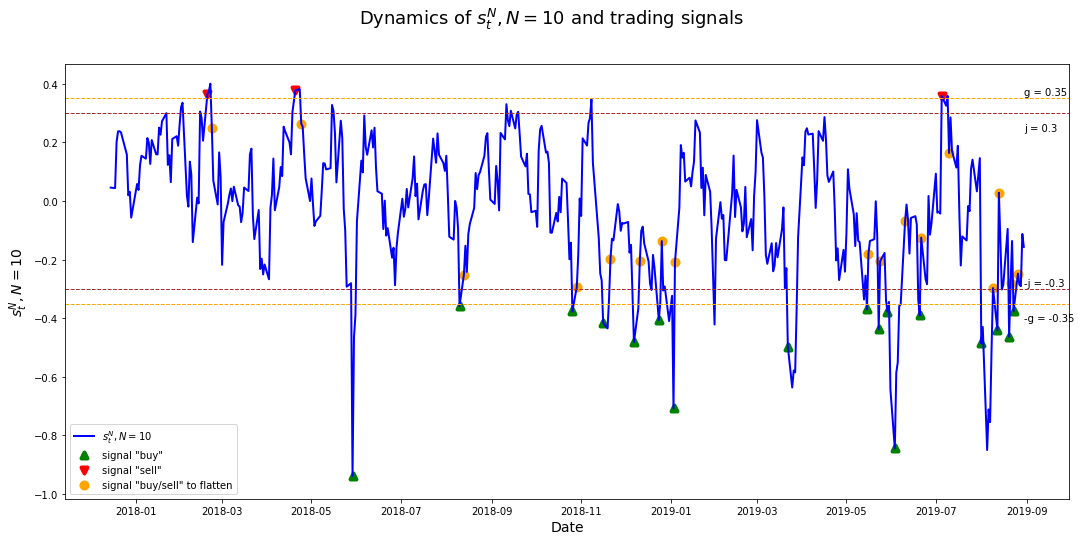

In [9]:
j=0.26
g=0.31
data, trades, pnl, ann_ret1, ann_ret2, ann_ret3, ann_ret4 = trading_strategy(data_df, j, g, S, K, False)
plot_signals(data, N)

j=0.3
g=0.35
data, trades, pnl, ann_ret1, ann_ret2, ann_ret3, ann_ret4 = trading_strategy(data_df, j, g, S, K, False)
plot_signals(data, N)

We can see from the table above that the strategy shows the best performance when we set thresholds $j$ and $g$ to be equal to $0.3$ and $0.35$ respectively. At the same time from the plots above we can see that **we achieve higher profitability of the strategy by exploiting downward trend of the spread and thus by opening mostly long positions.** 

Thus, in further analysis we will use $j=0.30, g=0.35$.

# 4. Analysis of Trading Strategy via ratios calculations and regressions

In [10]:
# SMB = Small - Big
# HML = High - Low

df_ff5 = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv', skiprows=3)
df_ff5.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_ff5['Date'] = pd.to_datetime(df_ff5['Date'],format='%Y%m%d')
df_ff5.drop(['RMW', 'CMA'], axis=1, inplace=True)

mask0 = datetime.strptime('2017-12-01', '%Y-%m-%d')
mask1 = datetime.strptime('2019-08-31', '%Y-%m-%d')

mask = (df_ff5['Date'] >= mask0) & (df_ff5['Date'] < mask1)
ff5 = df_ff5[mask]

stats = pd.DataFrame(index=['Strategy returns', 'SMB regression $\epsilon$', 'HML regression $\epsilon$', 
                            'Mkt-RF regression $\epsilon$', 'SMB, HML, Mkr-RF regression $\epsilon$'],
                    columns=['Sharpe Ratio original', 'Sharpe Ratio modified', 'Sortino Ratio'])

## 4.1. Sharpe and Sortino ratios 

$$ \text{Sharpe Ratio original} = \frac{E(r - r_f)}{\sqrt{E(r^2)}}$$

$$ \text{Sharpe Ratio modified} = \frac{E(r - r_f)}{\sqrt{E[(r-r_b)^2]}}$$

$$ \text{Sortino Ratio } = \frac{E(r - r_b)}{\sqrt{E[ (r-r_b)^2 | r < r_b ]}}$$

In [11]:
mask_SorR = (data['Daily_return'] < 0) 
data_SorR = data[mask_SorR]
print('Total number of days during the investment period = {} \nNumber of days with negative return = {}\n'.format(data.shape[0], 
                                                                        data_SorR.shape[0]))

print('Mean RFR = {:.5f}% \nMean of Strategy Returns = {:.5f}% \nStd.Dev. of Strategy Returns = {:.5f}'.format(ff5['RF'].mean()*100, 
                                                                                  data['Daily_return'].mean()*100,
                                                                                  data['Daily_return'].std()))

SR = (data['Daily_return'].mean() - ff5['RF'].mean()) / (data['Daily_return'].std())
SR_mod = (data['Daily_return'].mean() - 0) / (data['Daily_return'].std())
SorR = (data['Daily_return'].mean() - 0) / (data_SorR['Daily_return'].std())
print('Std.Dev. of negative Strategy Returns = {:.5f}\n'.format(data_SorR['Daily_return'].std()))

stats['Sharpe Ratio original']['Strategy returns'] = SR
stats['Sharpe Ratio modified']['Strategy returns'] = SR_mod
stats['Sortino Ratio']['Strategy returns'] = SorR

print('\nSharpe Ratio original = {:.3f}\n'.format(SR))
print('Sharpe Ratio modified = {:.3f}\n'.format(SR_mod))
print('Sortino Ratio = {:.3f}\n'.format(SorR))

Total number of days during the investment period = 443 
Number of days with negative return = 20

Mean RFR = 0.77039% 
Mean of Strategy Returns = 0.00150% 
Std.Dev. of Strategy Returns = 0.00018
Std.Dev. of negative Strategy Returns = 0.00021


Sharpe Ratio original = -43.048

Sharpe Ratio modified = 0.084

Sortino Ratio = 0.070



Let us use data on Fama-French factors which can be obtained from the website: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

We can see that for the period from 2017-12-01 to 2019-08-31 average risk-free rate was 0.77% and average return from our trading strategy is 0.00150% for the same period, what already tells us that our trading strategy performs quite bad. Let us further analyze Sharpe and Sortino ratios.

**Sharpe ratio original** is **-43.048** which tells us that performance of our trading strategy taking into account the OVERALL risk of our strategy (measured by standard deviation of daily returns) is below the risk-free rate, and we have negative excess returns. It was expected as mean return from our trading strategy is less than that of risk free rate.

**Sharpe ratio modified** is **0.084**, and zero was selected as a benchmark for its calculation, i.e. $r_b = 0$. Modified Sharpe Ratio tells us that performance of our trading strategy taking into account the OVERALL risk of our strategy is above the benchmark, and we have positive excess returns, i.e. in general we can just say that we have positive returns as benchmark is $0$. 

**Sortino Ratio** is **0.07**, and it tells us that performance of our trading strategy taking into account ONLY the DOWNSIDE RISK of our strategy (measured by standard deviation of negative daily returns) is above zero, and we have positive returns adjusted for downside risk.

## 4.2. Regression of strategy returns on Fama-French factors

### 4.2.1. Zero-intercept OLS, single-dimensional regression on SMB ("Small minus Big")

In [12]:
df_all = pd.merge(data, ff5, how='left', on='Date')

reg = sm.OLS(endog=df_all['Daily_return'], exog=df_all[['SMB']].assign(intercept=0), missing='drop')
res = reg.fit()
print(res.summary())

e = res.resid

e_df = pd.DataFrame(e, columns=['resid'])
mask_neg_e = (e_df['resid'] < 0) 
neg_e = e_df[mask_neg_e]
print('\n\nTotal number of days during the investment period considered = {} \nNumber of days with negative return = {}\n'.format(e_df.shape[0], 
                                                                        neg_e.shape[0]))

SR_e = (e.mean() - ff5['RF'].mean()) / e.std()
SR_e_mod = (e.mean() - 0) / e.std()
SorR_e = (e.mean() - 0) / neg_e['resid'].std()

stats['Sharpe Ratio original']['SMB regression $\epsilon$'] = SR_e
stats['Sharpe Ratio modified']['SMB regression $\epsilon$'] = SR_e_mod
stats['Sortino Ratio']['SMB regression $\epsilon$'] = SorR_e

print('Sharpe Ratio original = {:.3f}\n'.format(SR_e))
print('Sharpe Ratio modified = {:.3f}\n'.format(SR_e_mod))
print('Sortino Ratio = {:.3f}\n'.format(SorR_e))

                                 OLS Regression Results                                
Dep. Variable:           Daily_return   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.002
Method:                 Least Squares   F-statistic:                            0.09126
Date:                Thu, 23 Apr 2020   Prob (F-statistic):                       0.763
Time:                        16:39:26   Log-Likelihood:                          3085.8
No. Observations:                 429   AIC:                                     -6170.
Df Residuals:                     428   BIC:                                     -6166.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Fama-French factors are calculated using simple returns, that is why in our analysis we also use simple daily returns for our trading strategy. 

By doing regression of our trading strategy simple daily returns on Fama-French factor(s) we investigate **decomposition of our returns into various factors**. Beta(s) $\beta$ tell us that return from our trading strategy can be explained by those factors, and we can also hedge our portfolio by additionally investing in those factors in amount proportional to the corresponding beta $\beta$ of the factor. Alpha(s) $\alpha$ represent what is not explained by those factors.

Let us analyze Sharpe Ratio and Sortino ratio of residuals of regression.

**Sharpe Ratio original** is **-42.366**, which means that performance of our trading strategy "taking out" SMB factor (not considering part of returns that can be explained by SMB factor) and taking into account the OVERALL risk of our strategy w/o SMB factor exposure (measured by standard deviation of residuals) is below the risk-free rate, and we have negative excess returns. Value of Sharpe Ratio of residuals of regression of returns on SMB factor is very close to value of the Sharpe Ratio of actual trading strategy returns which is equal to -43.048. Thus, we can conclude that SMB factor does not extensively contribute to returns of our trading strategy, and investment into SMB factor (proportionally to its beta $\beta_{SMB}$) in addition to investment into our trading strategy **will not help us to improve performance of our investment portfolio significantly OVERALL.** At the same time we see that p-value is 0.763 and we can reject the Alternative Hypothesis (on 95% level) that SMB factor has correlation with our strategy returns.

**Sharpe Ratio modified** is **0.085**, and it tells us that performance of our trading strategy not considering part of returns that can be explained by SMB factor and taking into account the OVERALL risk of our strategy w/o SMB factor exposure is above zero. 

**Sortino ratio** is **0.146**, and it tells us that performance of our trading strategy not considering part of returns that can be explained by SMB factor and taking into account only the DOWNSIDE RISK of our strategy w/o SMB factor exposure is above zero, and we have positive returns not expalined by SMB adjusted for downside risk. We can also note that the Sortino Ratio of actual trading strategy returns is equal to 0.070 which is less than Sortino ratio of returns with SMB factor being "taken out". Thus, we can conclude that by investing both in our trading strategy and in SMB factor (proportionally to SMB beta $\beta_{SMB}$) we can **improve performance of our portfolio in the DOWNSIDE.**

### 4.2.2. Zero-intercept OLS, single-dimensional regression on HML ("High minus Low")

In [13]:
reg = sm.OLS(endog=df_all['Daily_return'], exog=df_all[['HML']].assign(intercept=0), missing='drop')
res = reg.fit()
print(res.summary())

e = res.resid

e_df = pd.DataFrame(e, columns=['resid'])
mask_neg_e = (e_df['resid'] < 0) 
neg_e = e_df[mask_neg_e]
print('Total number of days during the investment period considered = {} \nNumber of days with negative return = {}\n'.format(e_df.shape[0], 
                                                                        neg_e.shape[0]))

SR_e = (e.mean() - ff5['RF'].mean()) / e.std()
SR_e_mod = (e.mean() - 0) / e.std()
SorR_e = (e.mean() - 0) / neg_e['resid'].std()

stats['Sharpe Ratio original']['HML regression $\epsilon$'] = SR_e
stats['Sharpe Ratio modified']['HML regression $\epsilon$'] = SR_e_mod
stats['Sortino Ratio']['HML regression $\epsilon$'] = SorR_e

print('Sharpe Ratio original = {:.3f}\n'.format(SR_e))
print('Sharpe Ratio modified = {:.3f}\n'.format(SR_e_mod))
print('Sortino Ratio = {:.3f}\n'.format(SorR_e))

                                 OLS Regression Results                                
Dep. Variable:           Daily_return   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              3.790
Date:                Thu, 23 Apr 2020   Prob (F-statistic):                      0.0522
Time:                        16:39:26   Log-Likelihood:                          3087.6
No. Observations:                 429   AIC:                                     -6173.
Df Residuals:                     428   BIC:                                     -6169.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Sharpe Ratio original** is **-42.528**, which means that performance of our trading strategy "taking out" HML factor (not considering part of returns that can be explained by HML factor) and taking into account the OVERALL risk of our strategy w/o HML factor exposure (measured by standard deviation of residuals) is below the risk-free rate, and we have negative excess returns. Value of Sharpe Ratio of residuals of regression of returns on HML factor is very close to value of the Sharpe Ratio of actual trading strategy returns which is equal to -43.048. Thus, we can conclude that HML factor does not extensively contribute to returns of our trading strategy too, and investment into HML factor (proportionally to its beta $\beta_{HML}$) in addition to investment into our trading strategy **will not help us to improve performance of our investment portfolio significantly OVERALL.** At the same time we see that p-value is 0.052 and we can reject the Alternative Hypothesis (on 95% level) that HML factor has correlation with our strategy returns.

**Sharpe Ratio modified** is **0.076**, and it tells us that performance of our trading strategy not considering part of returns that can be explained by HML factor and taking into account the OVERALL risk of our strategy w/o HML factor exposure is above zero. 

**Sortino ratio** is **0.137**, and it tells us that performance of our trading strategy not considering part of returns that can be explained by HML factor and taking into account only the DOWNSIDE RISK of our strategy w/o HML factor exposure is above zero, and we have positive returns not expalined by HML adjusted for downside risk. We can also note that the Sortino Ratio of actual trading strategy returns is equal to 0.070 which is less than Sortino ratio of returns with HML factor being "taken out". Thus, we can conclude that by investing both in our trading strategy and in HML factor (proportionally to HML beta $\beta_{HML}$) we can **improve performance of our portfolio in the DOWNSIDE.**

### 3.2.3. Zero-intercept OLS, single-dimensional regression on Mkt-RF ("Market return minus risk-free rate")

In [14]:
reg = sm.OLS(endog=df_all['Daily_return'], exog=df_all[['Mkt-RF']].assign(intercept=0), missing='drop')
res = reg.fit()
print(res.summary())

e = res.resid

e_df = pd.DataFrame(e, columns=['resid'])
mask_neg_e = (e_df['resid'] < 0) 
neg_e = e_df[mask_neg_e]
print('\n\nTotal number of days during the investment period considered = {} \nNumber of days with negative return = {}\n'.format(e_df.shape[0], 
                                                                        neg_e.shape[0]))

SR_e = (e.mean() - ff5['RF'].mean()) / e.std()
SR_e_mod = (e.mean() - 0) / e.std()
SorR_e = (e.mean() - 0) / neg_e['resid'].std()

stats['Sharpe Ratio original']['Mkt-RF regression $\epsilon$'] = SR_e
stats['Sharpe Ratio modified']['Mkt-RF regression $\epsilon$'] = SR_e_mod
stats['Sortino Ratio']['Mkt-RF regression $\epsilon$'] = SorR_e

print('Sharpe Ratio original = {:.3f}\n'.format(SR_e))
print('Sharpe Ratio modified = {:.3f}\n'.format(SR_e_mod))
print('Sortino Ratio = {:.3f}\n'.format(SorR_e))

                                 OLS Regression Results                                
Dep. Variable:           Daily_return   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              2.583
Date:                Thu, 23 Apr 2020   Prob (F-statistic):                       0.109
Time:                        16:39:27   Log-Likelihood:                          3087.0
No. Observations:                 429   AIC:                                     -6172.
Df Residuals:                     428   BIC:                                     -6168.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Sharpe Ratio original** is **-42.487**, which means that performance of our trading strategy "taking out" Mkt-RF factor (not considering part of returns that can be explained by Mkt-RF factor) and taking into account the OVERALL risk of our strategy w/o Mkt-RF factor exposure (measured by standard deviation of residuals) is below the risk-free rate, and we have negative excess returns. Value of Sharpe Ratio of residuals of regression of returns on Mkt-RF factor is very close to value of the Sharpe Ratio of actual trading strategy returns which is equal to -43.048. Thus, we can conclude that Mkt-RF factor does not extensively contribute to returns of our trading strategy too, and investment into Mkt-RF factor (proportionally to its beta $\beta_{Mkt-RF}$) in addition to investment into our trading strategy **will not help us to improve performance of our investment portfolio significantly OVERALL.** At the same time we see that p-value is 0.109 and we can reject the Alternative Hypothesis (on 95% level) that Mkt-RF factor has correlation with our strategy returns.

**Sharpe Ratio modified** is **0.084**, and it tells us that performance of our trading strategy not considering part of returns that can be explained by Mkt-RF factor and taking into account the OVERALL risk of our strategy w/o Mkt-RF factor exposure is above zero. 

**Sortino ratio** is **0.147**, and it tells us that performance of our trading strategy not considering part of returns that can be explained by Mkt-RF factor and taking into account only the DOWNSIDE RISK of our strategy w/o Mkt-RF factor exposure is above zero, and we have positive returns not expalined by Mkt-RF adjusted for downside risk. We can also note that the Sortino Ratio of actual trading strategy returns is equal to 0.070 which is less than Sortino ratio of returns with Mkt-RF factor being "taken out". Thus, we can conclude that by investing both in our trading strategy and in Mkt-RF factor (proportionally to HML beta $\beta_{Mkt-RF}$) we can **improve performance of our portfolio in the DOWNSIDE.**

### 3.2.4. Zero-intercept OLS, multi-dimensional regression on SMB, HML, Mkt-RF factors

In [15]:
reg = sm.OLS(endog=df_all['Daily_return'], exog=df_all[['SMB', 'HML', 'Mkt-RF']].assign(intercept=0), missing='drop')
res = reg.fit()
print(res.summary())

e = res.resid

e_df = pd.DataFrame(e, columns=['resid'])
mask_neg_e = (e_df['resid'] < 0) 
neg_e = e_df[mask_neg_e]
print('\n\nTotal number of days during the investment period considered = {} \nNumber of days with negative return = {}\n'.format(e_df.shape[0], 
                                                                        neg_e.shape[0]))

SR_e = (e.mean() - ff5['RF'].mean()) / e.std()
SR_e_mod = (e.mean() - 0) / e.std()
SorR_e = (e.mean() - 0) / neg_e['resid'].std()

stats['Sharpe Ratio original']['SMB, HML, Mkr-RF regression $\epsilon$'] = SR_e
stats['Sharpe Ratio modified']['SMB, HML, Mkr-RF regression $\epsilon$'] = SR_e_mod
stats['Sortino Ratio']['SMB, HML, Mkr-RF regression $\epsilon$'] = SorR_e

print('Sharpe Ratio original = {:.3f}\n'.format(SR_e))
print('Sharpe Ratio modified = {:.3f}\n'.format(SR_e_mod))
print('Sortino Ratio = {:.3f}\n'.format(SorR_e))

                                 OLS Regression Results                                
Dep. Variable:           Daily_return   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              1.709
Date:                Thu, 23 Apr 2020   Prob (F-statistic):                       0.164
Time:                        16:39:27   Log-Likelihood:                          3088.3
No. Observations:                 429   AIC:                                     -6171.
Df Residuals:                     426   BIC:                                     -6158.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Sharpe Ratio original** is **-42.594**, which means that performance of our trading strategy "taking out" SMB, HML and Mkt-RF factors (not considering part of returns that can be explained by SMB, HML, Mkt-RF factors) and taking into account the OVERALL risk of our strategy w/o those factors exposure (measured by standard deviation of residuals) is below the risk-free rate, and we have negative excess returns. Value of Sharpe Ratio of residuals of regression of returns on 3 Fama-French factors is very close to value of the Sharpe Ratio of actual trading strategy returns which is equal to -43.048. Thus, we can conclude that SMB, HML and Mkt-RF factors does not extensively contribute to returns of our trading strategy too, and investment into those factors (proportionally to their betas ($\beta_{SMB}$, $\beta_{HML}$, $\beta_{Mkt-RF}$)) in addition to investment into our trading strategy **will not help us to improve performance of our investment portfolio significantly OVERALL.** At the same time we see that p-values are 0.691, 0.124 and 0.267 for SMB, HML and Mkt-RF respectively, and thus we can reject the Alternative Hypothesis (on 95% level) that those factors have correlation with our strategy returns.

**Sharpe Ratio modified** is **0.076**, and it tells us that performance of our trading strategy not considering part of returns that can be explained by SMB, HML and Mkt-RF factors and taking into account the OVERALL risk of our strategy w/o SMB, HML and Mkt-RF factors exposure is above zero. 

**Sortino ratio** is **0.136**, and it tells us that performance of our trading strategy not considering part of returns that can be explained by SMb, HML and Mkt-RF factors and taking into account only the DOWNSIDE RISK of our strategy w/o those factors exposure is above zero, and we have positive returns not expalined by SMB, HML and Mkt-RF adjusted for downside risk. We can also note that the Sortino Ratio of actual trading strategy returns is equal to 0.070 which is less than Sortino ratio of returns with SMB, HML and Mkt-RF factors being "taken out". Thus, we can conclude that by investing both in our trading strategy and in SMB, HML and Mkt-RF factors (proportionally to their betas ($\beta_{SMB}$, $\beta_{HML}$, $\beta_{Mkt-RF}$)) we can **improve performance of our portfolio in the DOWNSIDE.**

The comparison table of Sharpe and Sortino ratios for residuals of regressions is presented below.

In [16]:
stats

,Sharpe Ratio original,Sharpe Ratio modified,Sortino Ratio
Strategy returns,-43.0481,0.0841409,0.0699245
SMB regression $\epsilon$,-42.3657,0.0848055,0.146062
HML regression $\epsilon$,-42.5285,0.0764524,0.137321
Mkt-RF regression $\epsilon$,-42.4865,0.0838201,0.146803
"SMB, HML, Mkr-RF regression $\epsilon$",-42.5942,0.0758395,0.136019


We can conclude that trading strategy considered in this analysis which is generally based on mean reversion idea does not work well on Brent Crude Oil and Low Sulfur Gasoil futures spread. Partially this is explained by constant "mean reversion thresholds" $j$ and $g$ and downside trend of the spread itself. Parameters for which trading strategy showed the best performance are the following $j = 0.3$, $g = 0.35$, $N = 10$, $S = 0.00096$. Overall performance characteristics of trading strategy are:

- Cumulative PnL for the investment period = $6,178.90
- Annualized return = 0.24 %
- Sharpe ratio of trading strategy returns = -43.05
- Sharpe ratio of trading strategy returns = 0.08
- Sortino ratio = 0.07

Regression of trading strategy returns on each of SMB, HML, Mkt-RF factors separately and 3 factors together showed that we can improve performance of our strategy in the downside by investing in those factors in amount proportional to their betas, i.e. $\beta_{SMB}$, $\beta_{HML}$, $\beta_{Mkt-RF}$, in addition to investing in our trading strategy.